# 🚖 NYC Taxi Trip Duration Prediction

This project predicts the duration of taxi trips in New York City using machine learning.  
We will work on a real dataset from Kaggle containing over **1.4 million trips** collected in 2016.  

---

## 📌 Problem Statement
Given the pickup and dropoff coordinates, time of day, and passenger information,  
we aim to **predict the trip duration** in seconds.  

This is a **supervised regression problem**, where the target variable is `trip_duration`.  

---

## 🎯 Goals of the Project
1. Perform **Exploratory Data Analysis (EDA)** to understand the dataset.  
2. Clean and preprocess the data (remove outliers, fix missing values).  
3. Engineer useful features such as **distance** and **time-based features**.  
4. Build baseline machine learning models (Linear Regression, Decision Tree, Random Forest).  
5. Evaluate models using metrics like **MAE, RMSE, and R²**.  
6. Train a simple neural network with PyTorch.  
7. Save the final model and build a small **Streamlit demo app**.  

---

## 🛠️ Tools & Libraries
- Python, Pandas, NumPy  
- Matplotlib, Seaborn (for visualization)  
- Scikit-learn (for ML models)  
- PyTorch (for deep learning)  
- Streamlit (for app demo)

### 📌 Step 1 – Load Dataset
Load the NYC Taxi Trip dataset for analysis and modeling.

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\Users\SHIVANI\Desktop\nyc_taxi_project\data\train.csv")

# Print shape and first 5 rows
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### 📌 Step 2 – Data Cleaning
Remove invalid rows, fix datetime columns, and filter trips outside NYC bounds.

In [2]:
# 1. Remove rows with non-positive trip durations
df = df[df['trip_duration'] > 0].copy()

# 2. Convert datetime columns
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')

# 3. Trip duration statistics (before filtering outliers)
print("Trip Duration Statistics (before filtering):")
display(df[['trip_duration']].describe(percentiles=[0.5, 0.9, 0.99, 0.999]).T)

# 4. Check for missing values
print("\nMissing Values per Column:")
display(df.isnull().sum())

# 5. Define safe NYC latitude/longitude bounds
lat_min, lat_max = 40.5, 41.0
lon_min, lon_max = -74.25, -73.6

# 6. Apply geographic filter
mask = (
    df['pickup_latitude'].between(lat_min, lat_max) &
    df['dropoff_latitude'].between(lat_min, lat_max) &
    df['pickup_longitude'].between(lon_min, lon_max) &
    df['dropoff_longitude'].between(lon_min, lon_max)
)
df = df[mask].copy()

# 7. Remove extreme trip durations (above 99.9th percentile)
dur_cutoff = df['trip_duration'].quantile(0.999)
df = df[df['trip_duration'] <= dur_cutoff].copy()

# 8. Display updated dataset info
print("\nAfter cleaning:")
print("Dataset shape:", df.shape)
print("\nUpdated Trip Duration Statistics:")
display(df[['trip_duration']].describe(percentiles=[0.5, 0.9, 0.99, 0.999]).T)

Trip Duration Statistics (before filtering):


,count,mean,std,min,50%,90%,99%,99.9%,max
trip_duration,1458644.0,959.492273,5237.431724,1.0,662.0,1634.0,3440.0,85128.357,3526282.0



Missing Values per Column:


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


After cleaning:
Dataset shape: (1456524, 11)

Updated Trip Duration Statistics:


,count,mean,std,min,50%,90%,99%,99.9%,max
trip_duration,1456524.0,867.170437,1682.638727,1.0,662.0,1626.0,3344.0,5538.0,85127.0


### 📌 Step 3 – Feature Engineering
Create new features such as distance, pickup hour, weekday, and month.

In [3]:
import numpy as np

# 1. Define haversine distance function
def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate haversine distance (in kilometers) between two GPS points.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# 2. Create distance feature
df['distance_km'] = haversine_np(df['pickup_latitude'], df['pickup_longitude'],
                                 df['dropoff_latitude'], df['dropoff_longitude'])

# 3. Extract time-based features
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['pickup_month'] = df['pickup_datetime'].dt.month

# 4. Log-transform the target (trip_duration)
df['log_trip_duration'] = np.log1p(df['trip_duration'])

# 5. Preview new features
df[['trip_duration','log_trip_duration','distance_km','pickup_hour','pickup_dayofweek','pickup_month']].head()

,trip_duration,log_trip_duration,distance_km,pickup_hour,pickup_dayofweek,pickup_month
0,455,6.122493,1.498521,17,0,3
1,663,6.498282,1.805507,0,6,6
2,2124,7.661527,6.385098,11,1,1
3,429,6.063785,1.485498,19,2,4
4,435,6.077642,1.188588,13,5,3


### 📌 Step 4 – Exploratory Data Analysis (EDA)
Visualize trip duration, distance, and time patterns to find trends and outliers.

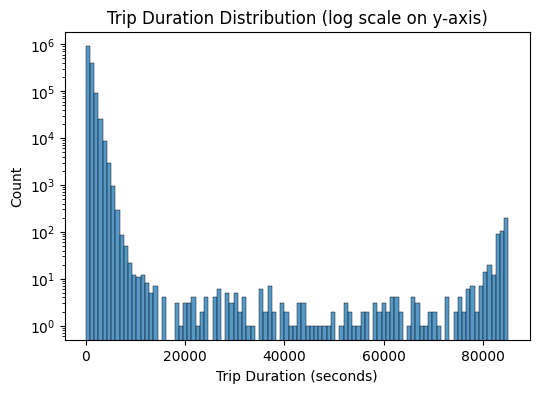

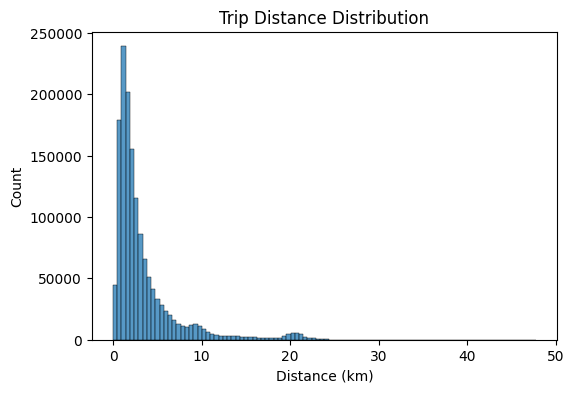

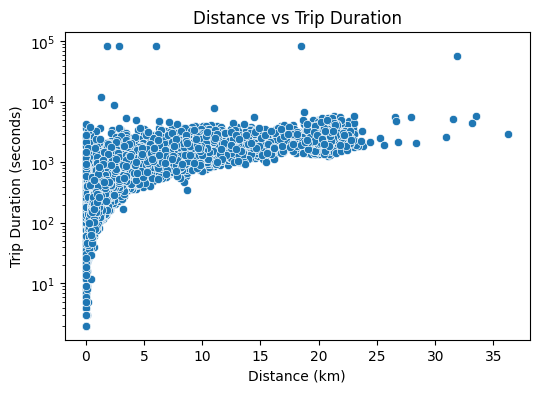

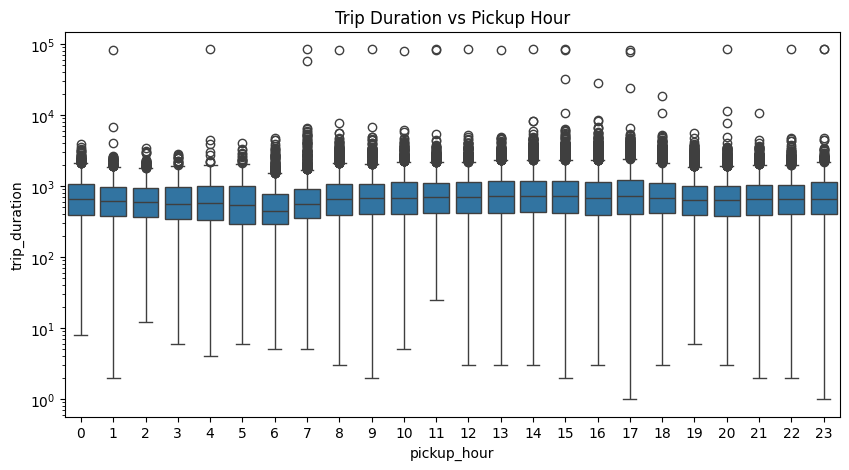

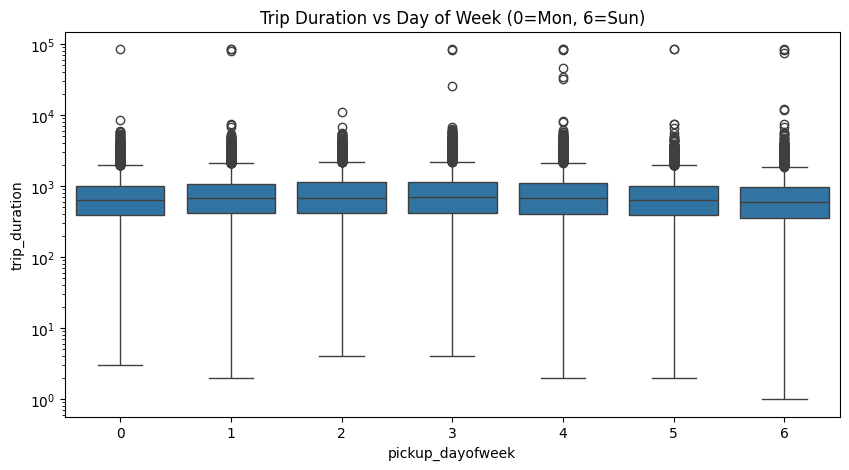

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of trip duration (log scale for clarity)
plt.figure(figsize=(6,4))
sns.histplot(df['trip_duration'], bins=100, kde=False)
plt.yscale('log')
plt.title("Trip Duration Distribution (log scale on y-axis)")
plt.xlabel("Trip Duration (seconds)")
plt.show()

# 2. Distribution of distance
plt.figure(figsize=(6,4))
sns.histplot(df['distance_km'], bins=100, kde=False)
plt.title("Trip Distance Distribution")
plt.xlabel("Distance (km)")
plt.show()

# 3. Scatterplot: distance vs trip duration
plt.figure(figsize=(6,4))
sns.scatterplot(x='distance_km', y='trip_duration', data=df.sample(20000))  # sample for speed
plt.yscale('log')
plt.title("Distance vs Trip Duration")
plt.xlabel("Distance (km)")
plt.ylabel("Trip Duration (seconds)")
plt.show()

# 4. Boxplot: trip duration by pickup hour
plt.figure(figsize=(10,5))
sns.boxplot(x='pickup_hour', y='trip_duration', data=df.sample(50000))
plt.yscale('log')
plt.title("Trip Duration vs Pickup Hour")
plt.show()

# 5. Boxplot: trip duration by day of week
plt.figure(figsize=(10,5))
sns.boxplot(x='pickup_dayofweek', y='trip_duration', data=df.sample(50000))
plt.yscale('log')
plt.title("Trip Duration vs Day of Week (0=Mon, 6=Sun)")
plt.show()

### 📌 Step 5 – Modeling (Baseline Models)
Train simple models (Linear Regression, Decision Tree) to set baseline performance.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# 1. Select features and target
features = ['distance_km', 'pickup_hour', 'pickup_dayofweek', 'pickup_month', 'passenger_count']
X = df[features]
y = df['log_trip_duration']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
}

# 4. Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}

# 5. Display results
import pandas as pd
results_df = pd.DataFrame(results).T
results_df

,MAE,RMSE,R²
Linear Regression,0.443142,0.595520,0.417108
Decision Tree,0.314736,0.440731,0.680741
Random Forest,0.312691,0.437679,0.685148


### 📌 Step 6 – Model Evaluation
Compare ML models using metrics (R², MAE, RMSE) and visualize results with bar plots.

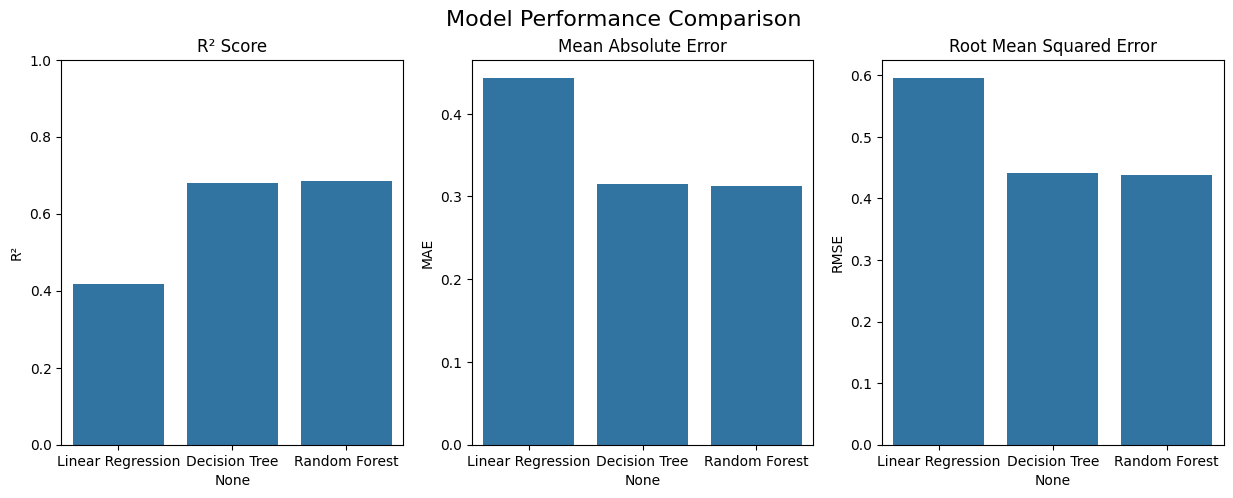

In [6]:
# Bar plots for comparison
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# R²
sns.barplot(x=results_df.index, y="R²", data=results_df, ax=axes[0])
axes[0].set_title("R² Score")
axes[0].set_ylim(0,1)

# MAE
sns.barplot(x=results_df.index, y="MAE", data=results_df, ax=axes[1])
axes[1].set_title("Mean Absolute Error")

# RMSE
sns.barplot(x=results_df.index, y="RMSE", data=results_df, ax=axes[2])
axes[2].set_title("Root Mean Squared Error")

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.show()

### 📌 Step 7 – Save Final Model
Save the best-performing Random Forest model for later use and reload it to test predictions.

In [7]:
import joblib

# Save the Random Forest model inside app folder
joblib.dump(models["Random Forest"], "../app/random_forest_model.pkl")

print("✅ Model saved at ../app/random_forest_model.pkl")

✅ Model saved at ../app/random_forest_model.pkl


In [8]:
# Load the saved model
rf_loaded = joblib.load("../app/random_forest_model.pkl")

# Test prediction on one sample
sample = X_test.iloc[0:1]
pred = rf_loaded.predict(sample)

print("Predicted log_trip_duration:", pred)
print("Predicted trip_duration (seconds):", np.expm1(pred))

Predicted log_trip_duration: [6.15778722]
Predicted trip_duration (seconds): [471.38163902]


 ### 📌 Step 8 – Neural Network with PyTorch
Train a simple feedforward neural network on a sample of the dataset and evaluate its performance.

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1. Use a smaller sample for speed
df_torch = df.sample(100000, random_state=42)

X = df_torch[features].values
y = df_torch['log_trip_duration'].values

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Train-test split (80-20)
split = int(0.8 * len(X_tensor))
X_train_t, X_test_t = X_tensor[:split], X_tensor[split:]
y_train_t, y_test_t = y_tensor[:split], y_tensor[split:]

# Create DataLoader
train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

# 2. Define a simple feedforward network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = Net()

# 3. Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Train the network
epochs = 5
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = criterion(pred, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# 5. Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test_t).numpy()
    
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test_t, preds)
rmse = np.sqrt(mean_squared_error(y_test_t, preds))
r2 = r2_score(y_test_t, preds)

print("\nNeural Network Performance:")
print("MAE:", mae, "RMSE:", rmse, "R²:", r2)

Epoch 1/5, Loss: 0.1892
Epoch 2/5, Loss: 0.3472
Epoch 3/5, Loss: 0.1485
Epoch 4/5, Loss: 0.1991
Epoch 5/5, Loss: 0.1814

Neural Network Performance:
MAE: 0.3414614796638489 RMSE: 0.47163856911570545 R²: 0.6346303820610046


### 📌 Conclusion

We built a machine learning pipeline to predict NYC taxi trip durations. After data cleaning, feature engineering, and testing models, the Random Forest performed best among the baseline models. A simple PyTorch neural network also showed potential. Finally, we deployed the model with Streamlit for real-time trip duration prediction.